Here we'll be making a GAN to generate preferences.

In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
from IPython import display

from loggingutils import Logger

from IPython.core.interactiveshell import InteractiveShell


import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

import tqdm
from tqdm import tqdm_notebook

## Load Data

#### Define the dataloader structure

In [3]:
%autoreload 2
import importlib
import preference_loader as pl
data = pl.Dataset('../data_in/Practice/ED-02-Logo.soi')
data_loader = torch.utils.data.DataLoader(data, batch_size=20, shuffle=False)
num_batches = len(data_loader)
data.pairs[0], data.votes[0]

(tensor([-1.,  0.,  0.,  0.,  0., -1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,
          0.,  0., -1.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0., -1.,  0.,  1.]),
 array([2, 7, 0, 0, 0, 0, 0, 0]))

[6 4 8 0 0 0 0 0]
tensor([ 0.,  0., -1.,  0., -1.,  0., -1.,  0., -1.,  0., -1.,  0., -1., -1.,
         0., -1.,  0., -1.,  1., -1.,  1.,  1., -1.,  0., -1.,  1.,  1., -1.])


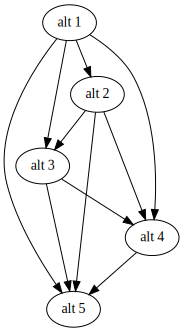

In [4]:
# testing graph_visualization
%autoreload 2
# InteractiveShell.ast_node_interactivity = "all"
import graph_visualize as gv
i = 90
print(data.votes[i])
print(data.pairs[i])
gv.vec_to_graph(data.pairs[i])
gv.vote_to_graph([1,2,3,4,5])

#### Shape of the data

In [5]:
# InteractiveShell.ast_node_interactivity = "last_expr'"
num_votes = len(data)
num_features = len(data.pairs[-1])
num_votes, num_features
print(data_loader)
print(data_loader.dataset[0])

tensor([-1.,  0.,  0.,  0.,  0., -1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,
         0.,  0., -1.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0., -1.,  0.,  1.])


## Networks

In [6]:
'''
Originally was N -- 1024 -- 512 -- 256 -- 1
'''
N = num_features
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = N
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(N, N),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(N, N),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(N, N),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(N, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
# def matrix_to_vectors(images):
#     return images.view(images.size(0), 784)

# def vectors_to_images(vectors):
#     return vectors.view(vectors.size(0), 1, 28, 28)

In [7]:
'''
original architecture was in -- 256 -- 512 -- 1024 -- out
         new architecture is -- in  -- in  -- in   -- out
'''
N = num_features

class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = N
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, N),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(N, N),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(N, N),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(N, N),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n

## Send networks to GPU if available

In [8]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
    print('GPU available')
    discriminator.cuda()
    generator.cuda()

GPU available


## Optimization

In [18]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 100

## Training

In [10]:
'''
The author of this blog post
https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9
suggest using real=0 and fake=1 for improvbed 'gradient flow in the early generations'
'''

def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [11]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

### Generate Samples for Testing

In [12]:
num_test_samples = 2
test_noise = noise(num_test_samples)
test_noise

tensor([[ 3.8923e-01,  2.8270e-01,  7.2138e-01,  1.6612e-01, -4.5024e-01,
         -1.0845e-01,  2.3590e+00,  9.2136e-01,  3.0629e-01, -8.2274e-01,
         -1.0791e+00,  2.9833e-01, -9.4099e-01,  1.0870e+00,  2.1204e-01,
          1.6900e+00, -3.5728e-01, -8.2072e-01, -8.1737e-01, -8.7234e-01,
         -3.0101e-01, -1.2455e+00, -4.2359e-01,  5.0665e-01, -9.5803e-01,
         -6.6709e-01,  5.5204e-02, -1.0058e+00,  7.1098e-01,  5.6201e-01,
         -1.8578e+00,  3.9369e-01,  1.1331e+00,  1.6190e-01,  1.3267e+00,
         -6.8871e-01, -5.6794e-01, -1.1228e+00, -3.5907e-01,  4.2743e-01,
         -5.9979e-01, -2.2550e-01,  8.2675e-01,  2.2731e+00,  3.5761e-01,
         -5.4994e-01,  7.5657e-01,  2.2210e+00, -5.0252e-01,  6.4752e-01,
         -6.3648e-01,  1.2911e+00, -6.2430e-01,  1.2882e+00,  6.0382e-01,
          5.3251e-01,  3.5169e-01,  2.9058e-01, -3.9930e-02, -5.2387e-01,
          1.1795e-01,  6.4722e-01, -2.3848e+00,  3.4342e-01,  4.4896e-01,
         -1.6352e+00,  1.4768e-01,  6.

### Start training

In [20]:
%%time

logger = Logger(model_name='VGAN', data_name='MNIST')

for epoch in range(num_epochs):
    # for n_batch, (real_batch,_) in enumerate(data_loader):
    for n_batch, real_batch in enumerate(data_loader):

        # 1. Train Discriminator
        # real_data = Variable(images_to_vectors(real_batch))
        real_data = Variable(real_batch)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # Display Progress
        if (n_batch) % 4 == 0:
            display.clear_output(True)
            # Display Graph
            test_vote = generator(test_noise).data.cpu()
            gv.vec_to_graph(data.pairs[i])
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        # logger.save_models(generator, discriminator, epoch)

Epoch: [99/100], Batch Num: [4/8]
Discriminator Loss: 0.0561, Generator Loss: 6.6520
D(x): 0.0354, D(G(z)): 0.9969
Wall time: 17.8 s
